In [1]:
from ipytables import *

In [2]:
import pylab as pl
%matplotlib inline
pl.rcParams['figure.figsize'] = 10, 5


In [3]:
import itertools
import os.path
import csv
import numpy as np
import scipy.spatial
import pandas as pd
pd.options.display.max_rows=20
pd.options.display.max_seq_items = 100
pd.options.display.max_colwidth = 100

In [4]:
os.chdir("prepared_corpora/opinosis/")

In [5]:
def load_pf_group_index():
    df = pd.read_csv("./phrase_groups.csv")
    df.set_index(["paraphrase_group_index", "phrase_index"], inplace=True)
    return df
    

In [6]:
df = load_pf_group_index()
df["tokenized_phrases"]=[line.strip() for line in open("tokenized_phrases.txt","r")]


In [7]:
df["pvdm"]=list(np.loadtxt("outVectors_wiki_sentence_concat_pvdm.csv", delimiter=","))
df["dbow"]=list(np.loadtxt("outVectors_wiki_sentence_dbow.csv", delimiter=","))
df["urae"]=list(np.loadtxt("outVectors_RAE2011.csv", delimiter=","))
df["bow"]=list(np.loadtxt("outVectors_bow.csv", delimiter=","))


In [40]:
from sklearn.decomposition import PCA
df["pca_bow"] = list(PCA(300, whiten=False).fit_transform(np.row_stack(list(df.bow))))

In [54]:
#Just consider paraphrase groups of a certain size
df = df.groupby(level=0).filter(lambda group: len(group)>4)

In [10]:
#Dervived combined models
#ensembles = list(itertools.combinations(df.columns[1:],2))
#for ensemble in ensembles:
#    df["_".join(ensemble)] = df[ensemble[0]].combine(df[ensemble[1]], func=lambda a,b: np.concatenate((a,b)))


In [11]:
df

tokenized_phrases  \
paraphrase_group_index phrase_index                                                                                                        
1                      2             speaking of which , the keyboard 's relatively large size , at 92 % of the size of a normal one ...   
                       3                                            the keyboard , more than 90 % standard size , is just large enough .   
                       4                                            the keyboard is large enough to accommodate touch typing with ease .   
                       5                                                 speaking of typing , the keyboard is great , almost full size .   
                       6                                                it 's 90 % size keyboard does n't take too long to get used to .   
                       7                          the keyboard is only slightly smaller than a regular one , so it 's very comfortable .   
                       8                                    the keyboard is nearly full size and very comfortable to type on for hours .   
2                      9                                         the keyboard is functional , but takes a little bit of getting use to .   
                       10                                                                  the keyboard takes a bit of getting used to .   
                       11                                                       keyboard feels funny at first , but you get used to it .   
...                                                                                                                                  ...   
158                    657                                                                            but , it 's always very accurate .   
159                    658                                        it has yet to disappoint , getting me everywhere with 100 % accuracy .   
                       659                                                              the directions are highly accurate down to a t .   
                       660                                             it got me from point a to point b with 100 % accuracy everytime .   
160                    661                                                             most of the times , this info was very accurate .   
                       662                                               the directions provided have all been quite accurate thus far .   
                       663                                 aside from that , every destination i 've thrown at has been 100 % accurate .   
161                    664                                                          to date it 's been a very easy to use and accurate .   
                       665                                                         easy to use and amazed at how accurate this item is .   
                       666                                             easy to use , excellent accuracy , nice and intuitive interface .   

                                                                                                                                    pvdm  \
paraphrase_group_index phrase_index                                                                                                        
1                      2             [-0.117434248328, -0.015163497068, -0.0158847086132, 0.0758114904165, -0.00432644132525, 0.03714...   
                       3             [-0.00158204487525, 0.0420459918678, 0.00303942873143, 0.0266706366092, -0.00238277693279, -0.02...   
                       4             [0.0286828167737, 0.0231479890645, 0.0258000101894, -0.00616379966959, -0.0199173390865, -0.0397...   
                       5             [-0.0913886651397, 0.0399422906339, 0.0419003777206, -0.00510333757848, -0.00751925306395, 0.002...   
                       6             [-0.0729923397303, -0

In [12]:
from matplotlib import colors as mpl_colors
import matplotlib.cm as cm

from collections import Counter
import random



lbls = df.index.get_level_values(0)
color_names = cm.Dark2 (np.linspace(0.0, 1, len(np.unique(lbls))))
color_dict = dict(zip(np.unique(lbls), color_names))
colors = [color_dict[lbl] for lbl in lbls]


names = df.tokenized_phrases.groupby(level=0).first()
Table(*[TableRow(TableCell(name,bg_colour=rgba_to_string(color_dict[id]))) for id, name in list(names.to_dict().items())])



"speaking of which , the keyboard 's relatively large size , at 92 % of the size of a normal one , writing longer texts on it is no problem ."
"the keyboard is functional , but takes a little bit of getting use to ."
the keyboard is surprisingly good for someone like me with big hands .
the screen is easy on the eyes .
i also really like the way it shows my speed and the posted speed limit .
indicates posted speed limits of the road you are on
"free wifi in your room , and the free wine reception in the evenings was great ."
"the nightly free wine tasting from 5 , 6 pm is a brilliant idea and gets guests together to socialise witheach other ."
excellent free wine reception in evening .
the hotel offers free wifi to all guests who have a laptop .
the free morning coffee and evening wine reception were both good opportunities to meet other guests .


In [13]:
from sklearn.manifold import t_sne
def plot_tsne(column):
    tsne = t_sne.TSNE()
    Ys = tsne.fit_transform(np.row_stack(df[column]))
    
    pl.scatter(Ys[:,0],Ys[:,1], c=colors)
    pl.title = column
    
    

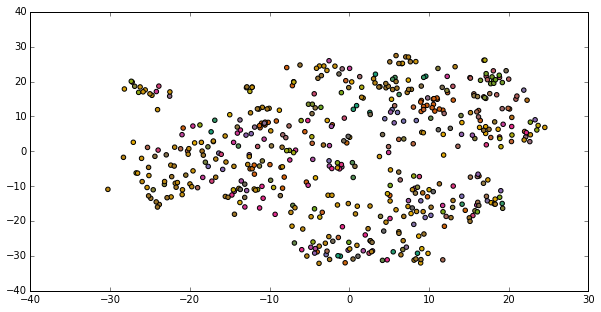

In [14]:
plot_tsne("urae")

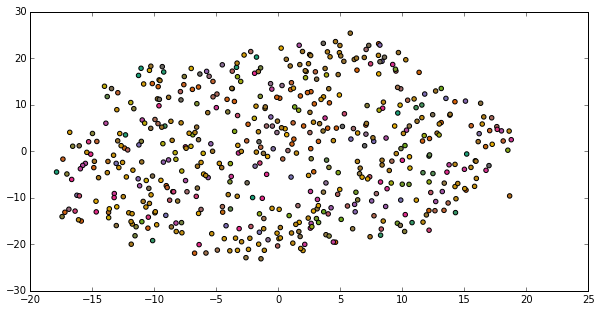

In [15]:
plot_tsne("pvdm")

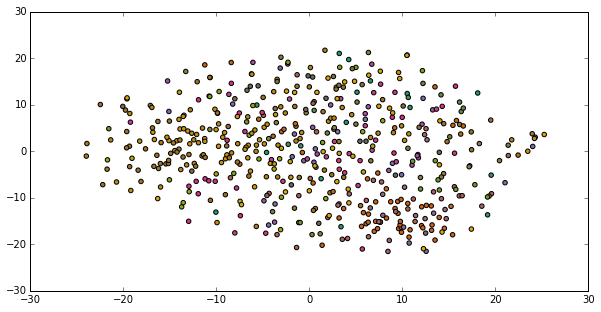

In [16]:
plot_tsne("dbow")

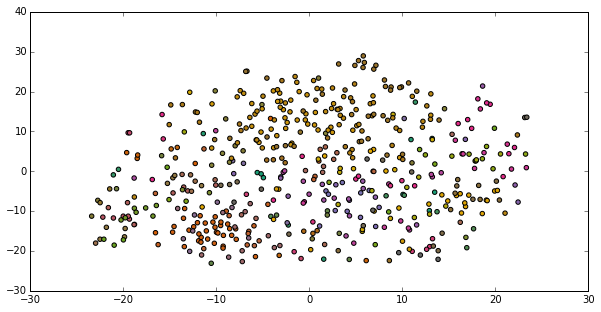

In [17]:
plot_tsne("bow")

#Wei's method


1. within each paraphrase group, for each model, work out average pair-wise cosine similarity (or distance)
2. treat each model's average similarity/distance for the paraphrase groups as a time series, do a z-normalisation () the time (horizontal) axis is the paraphrase group index, and the y axis is the similarity value after the z-normalisation
3. measure the similarity between the four model time series, pair-wise using Euclidean distance to see which model agrees with each other. 
4. the ground truth in this case should be horizontal x axis, which means the best values that each model gets should be close to zero (if you use similarity, rather than distance). So the model with an overall trend of low similarity values capture the semantics better.

In [18]:
import scipy.spatial.distance as distance

def angular_dist(a,b):
    cos_sim = np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return np.arccos(cos_sim)*(2/np.pi)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec13ceac88>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fec13b485f8>]], dtype=object)

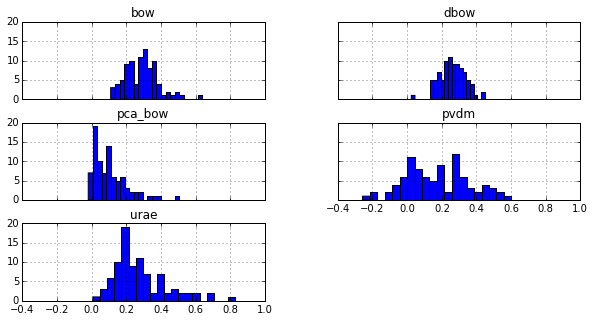

In [19]:
def get_group_sim(group):
    xs = np.row_stack(group)
    #cosine_sim = (1-distance.pdist(xs, 'cosine'))
    sim = 1-distance.pdist(xs,angular_dist)
    return sim.mean()

group_sims = df.groupby(level=0).agg(get_group_sim)
group_sims.hist(bins=20, sharex=True, sharey=True)

In [20]:
def z_norm(col):
    return (col-col.mean())/col.std()

n_group_sims = group_sims.apply(z_norm)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec13d62c18>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fec139055f8>]], dtype=object)

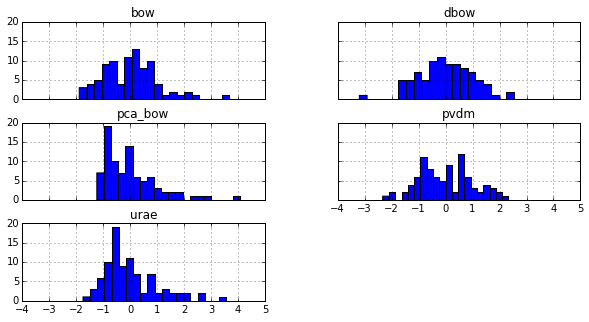

In [21]:
n_group_sims.hist(bins=20, sharex=True, sharey=True)

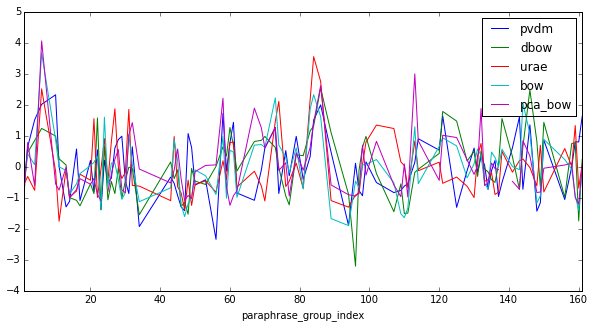

In [22]:
n_group_sims.plot()

              pvdm       dbow       urae       bow  pca_bow
pvdm      0.000000  10.106519  11.455488  9.723450      NaN
dbow     10.106519   0.000000  11.406137  8.599245      NaN
urae     11.455488  11.406137   0.000000  8.371226      NaN
bow       9.723450   8.599245   8.371226  0.000000      NaN
pca_bow        NaN        NaN        NaN       NaN        0


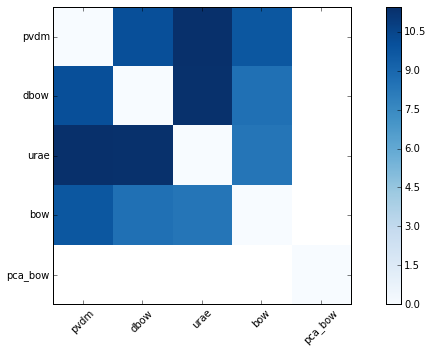

In [23]:
import matplotlib.cm as cm
def plot_matrix(cm, labels, cmap=cm.Blues):
    pl.imshow(cm, interpolation='nearest', cmap=cmap)
    pl.colorbar()
    tick_marks = np.arange(len(labels))
    pl.xticks(tick_marks, labels, rotation=45)
    pl.yticks(tick_marks, labels)
    pl.tight_layout()
    
def get_interrater_e_distance(ratings):
    rating_dist = distance.pdist(n_group_sims.as_matrix().T)
    return distance.squareform(rating_dist)

interrater_e_distance = get_interrater_e_distance(n_group_sims)
print(pd.DataFrame( interrater_e_distance, columns =n_group_sims.columns, index=n_group_sims.columns))
      
plot_matrix(interrater_e_distance, n_group_sims.columns)

In [24]:
def get_centroid(group):
    xs = np.row_stack(group)
    return list(xs.mean(axis=0)) #Euclidean



def get_medoid(group):
    points=np.row_stack(group)
    ingroup_index = distance.cdist(points,points, 'cosine').sum(axis=1).argmin()
    return list(points[ingroup_index,:])


def get_angular_centroid(group):
    # the angular centroid is a line, here we choes an arbitairy point on it.
    # Dicussion of how normalising and adding wroks is at http://math.stackexchange.com/a/925659/1505
    points = np.row_stack(group)
    unit_points = points/np.linalg.norm(points,axis=1)[:,None]  #Normalise ot unit vectors
    return list(np.sum(unit_points,axis=0))
    

def get_group_medoids(series):
    return series.groupby(level=0).agg(get_medoid)


def get_group_centroids(series):
    return series.groupby(level=0).agg(get_centroid)


In [25]:

#Davies-Bouldin Index 
#Modified to use angular centroid, and angular distance

def davied_bouldin_index(series):

    def av_dist_to_centroid(group):
        xs = np.row_stack(group)
        c = get_angular_centroid(group)
        return distance.cdist(xs,[c], angular_dist).mean()

    group_centroids = get_group_centroids(series)
    group_spreads = series.groupby(level=0).agg(av_dist_to_centroid)
    
    n_groups = len(group_spreads)
    
    total = 0.0
    for ii in range(n_groups):
        greatest = -1*np.Inf
        for jj in range(n_groups):
            if ii==jj:
                continue

            numer = group_spreads.iloc[ii] + group_spreads.iloc[jj] 
            denom = angular_dist(group_centroids.iloc[ii],group_centroids.iloc[jj]) #Euclidean
            value = numer/denom
            greatest = max(greatest, value)
        total+= greatest
    return total/n_groups

            
for column in df.columns[1:]:
    print(column + " " + str(davied_bouldin_index(df.loc[:,column])))

pvdm 2.99873855232
dbow 2.10135038669
urae 2.64383871483
bow 1.84434597704
pca_bow 1.45048037077


In [26]:
#Ideal spherical K-Mean-ish 1 Pass. 
#Only need one pass, since we set the centroid with the True Centroid based on the groups.

def get_classes(series, center_fun):
    group_centers = np.row_stack(series.groupby(level=0).agg(center_fun)) 
    points  = np.row_stack(series)
    class_indexes = distance.cdist(points,group_centers, 'cosine').argmin(axis=1)
    return np.asarray(series.index[class_indexes].labels[0])
    
def get_true_classes(series):
    return np.asarray([ii[0] for ii in series.index])

def recluster_success(series):
    true_classes = get_true_classes(series)

    def get_acc(center_fun):
        classes = get_classes(series, center_fun)
        return (classes == true_classes).sum()/len(true_classes)
    

    return pd.Series([get_acc(get_centroid),
                      get_acc(get_medoid),
                      get_acc(get_angular_centroid)
                     ], index="centroid_acc medoid_acc angular_centroid_acc".split()) 
    

recluster_results = pd.DataFrame()
for column in df.columns[1:]:
    recluster_results[column] = recluster_success(df[column])

recluster_results

,pvdm,dbow,urae,bow,pca_bow
centroid_acc,0.026871,0.013436,0.011516,0.013436,0.013436
medoid_acc,0.030710,0.011516,0.013436,0.007678,0.013436
angular_centroid_acc,0.028791,0.015355,0.009597,0.013436,0.015355


In [27]:
#Lets take a look at what mistakes are being made.
#We can look at the exemplary member of each class as a repressentitive,
#And can compare that for the class it was given to that for the class it should have been given

def get_exemplars(df, col_name, get_center_fun):
    series = df[col_name]
    def get_exemplar(group):
        c = get_center_fun(group)
        points=np.row_stack(group)
        ingroup_index = distance.cdist(points,[c], 'cosine').flatten().argmin()
        df_index = group.index[ingroup_index]
        return df.tokenized_phrases[df_index]
    
    return series.groupby(level=0).agg(get_exemplar)



def get_mistakes(df, col_name, get_center_fun=get_angular_centroid):
    group_exemplars = get_exemplars(df, col_name,get_center_fun)
    
    series = df[col_name]
    
    classes = get_classes(series, get_center_fun)
    true_classes = get_true_classes(series)
    
    mistake_indexs = np.nonzero(classes!=true_classes)
    
    
    ret = pd.DataFrame()
    ret["mistaken_texts"] = list(df.tokenized_phrases.iloc[mistake_indexs])
    ret["expected_exemplar"] = list(group_exemplars[true_classes[mistake_indexs]])
    ret["actual_exemplar"] = list(group_exemplars[classes[mistake_indexs]])
    
    return ret


In [28]:
get_mistakes(df, "bow",get_angular_centroid)

,mistaken_texts,expected_exemplar,actual_exemplar
0,"the keyboard is functional , but takes a little bit of getting use to .","the keyboard is functional , but takes a little bit of getting use to .","speaking of typing , the keyboard is great , almost full size ."
1,the keyboard takes a bit of getting used to .,"the keyboard is functional , but takes a little bit of getting use to .","speaking of typing , the keyboard is great , almost full size ."
2,"keyboard feels funny at first , but you get used to it .","the keyboard is functional , but takes a little bit of getting use to .","speaking of typing , the keyboard is great , almost full size ."
3,the keyboard is surprisingly good for someone like me with big hands .,i am 5'10 with large hands and have no problem using the keyboard .,"speaking of typing , the keyboard is great , almost full size ."
4,i have large hands and with a little time on the keyboard i 'm breezing through word processing ...,i am 5'10 with large hands and have no problem using the keyboard .,"speaking of typing , the keyboard is great , almost full size ."
5,i am 5'10 with large hands and have no problem using the keyboard .,i am 5'10 with large hands and have no problem using the keyboard .,"speaking of typing , the keyboard is great , almost full size ."
6,the keyboard is quite nice and i have very large hands and i make a lot fewer mistakes .,i am 5'10 with large hands and have no problem using the keyboard .,"speaking of typing , the keyboard is great , almost full size ."
7,the screen is easy on the eyes .,the screen is easy on the eyes .,"speaking of typing , the keyboard is great , almost full size ."
8,the screen is so easy on the eyes .,the screen is easy on the eyes .,"speaking of typing , the keyboard is great , almost full size ."
9,the text is easy on my eyes .,the screen is easy on the eyes .,"speaking of typing , the keyboard is great , almost full size ."


In [29]:
get_mistakes(df, "urae",get_angular_centroid)

,mistaken_texts,expected_exemplar,actual_exemplar
0,"the keyboard , more than 90 % standard size , is just large enough .",the keyboard is large enough to accommodate touch typing with ease .,the hotel has free wireless .
1,the keyboard is large enough to accommodate touch typing with ease .,the keyboard is large enough to accommodate touch typing with ease .,i liked the way it tells you the speed limit and how fast you are going .
2,"speaking of typing , the keyboard is great , almost full size .",the keyboard is large enough to accommodate touch typing with ease .,the staff was friendly and helpful .
3,it 's 90 % size keyboard does n't take too long to get used to .,the keyboard is large enough to accommodate touch typing with ease .,i have large hands and with a little time on the keyboard i 'm breezing through word processing ...
4,"the keyboard is only slightly smaller than a regular one , so it 's very comfortable .",the keyboard is large enough to accommodate touch typing with ease .,the free morning coffee and evening wine reception were both good opportunities to meet other gu...
5,the keyboard is nearly full size and very comfortable to type on for hours .,the keyboard is large enough to accommodate touch typing with ease .,i liked the way it tells you the speed limit and how fast you are going .
6,"the keyboard is functional , but takes a little bit of getting use to .",the keyboard takes a bit of getting used to .,the keyboard is large enough to accommodate touch typing with ease .
7,the keyboard takes a bit of getting used to .,the keyboard takes a bit of getting used to .,the keyboard is large enough to accommodate touch typing with ease .
8,"keyboard feels funny at first , but you get used to it .",the keyboard takes a bit of getting used to .,the keyboard is large enough to accommodate touch typing with ease .
9,the keyboard is surprisingly good for someone like me with big hands .,i have large hands and with a little time on the keyboard i 'm breezing through word processing ...,i liked the way it tells you the speed limit and how fast you are going .


In [30]:
get_mistakes(df, "pvdm",get_medoid)

,mistaken_texts,expected_exemplar,actual_exemplar
0,"speaking of which , the keyboard 's relatively large size , at 92 % of the size of a normal one ...","speaking of typing , the keyboard is great , almost full size .",all staff were very helpful and friendly .
1,"the keyboard , more than 90 % standard size , is just large enough .","speaking of typing , the keyboard is great , almost full size .",all staff were very helpful and friendly .
2,the keyboard is large enough to accommodate touch typing with ease .,"speaking of typing , the keyboard is great , almost full size .",the hotel offers free wifi to all guests who have a laptop .
3,it 's 90 % size keyboard does n't take too long to get used to .,"speaking of typing , the keyboard is great , almost full size .",we did however make use of the free tea and coffee when we had an early start .
4,"the keyboard is only slightly smaller than a regular one , so it 's very comfortable .","speaking of typing , the keyboard is great , almost full size .","we went down for the free wine reception , and had a great time ."
5,the keyboard is nearly full size and very comfortable to type on for hours .,"speaking of typing , the keyboard is great , almost full size .",all staff were very helpful and friendly .
6,"the keyboard is functional , but takes a little bit of getting use to .",the keyboard takes a bit of getting used to .,all staff were very helpful and friendly .
7,the keyboard takes a bit of getting used to .,the keyboard takes a bit of getting used to .,"speaking of typing , the keyboard is great , almost full size ."
8,the keyboard is surprisingly good for someone like me with big hands .,i am 5'10 with large hands and have no problem using the keyboard .,all staff were very helpful and friendly .
9,i have large hands and with a little time on the keyboard i 'm breezing through word processing ...,i am 5'10 with large hands and have no problem using the keyboard .,i also really like the way it shows my speed and the posted speed limit .


In [31]:
get_mistakes(df, "dbow",get_angular_centroid)

,mistaken_texts,expected_exemplar,actual_exemplar
0,"the keyboard is functional , but takes a little bit of getting use to .","keyboard feels funny at first , but you get used to it .","the keyboard , more than 90 % standard size , is just large enough ."
1,the keyboard takes a bit of getting used to .,"keyboard feels funny at first , but you get used to it .","the keyboard , more than 90 % standard size , is just large enough ."
2,"keyboard feels funny at first , but you get used to it .","keyboard feels funny at first , but you get used to it .","the keyboard , more than 90 % standard size , is just large enough ."
3,the keyboard is surprisingly good for someone like me with big hands .,i am 5'10 with large hands and have no problem using the keyboard .,"the keyboard , more than 90 % standard size , is just large enough ."
4,i have large hands and with a little time on the keyboard i 'm breezing through word processing ...,i am 5'10 with large hands and have no problem using the keyboard .,"the keyboard , more than 90 % standard size , is just large enough ."
5,i am 5'10 with large hands and have no problem using the keyboard .,i am 5'10 with large hands and have no problem using the keyboard .,"the keyboard , more than 90 % standard size , is just large enough ."
6,the keyboard is quite nice and i have very large hands and i make a lot fewer mistakes .,i am 5'10 with large hands and have no problem using the keyboard .,"the keyboard , more than 90 % standard size , is just large enough ."
7,the screen is easy on the eyes .,the screen is easy on the eyes .,"the keyboard , more than 90 % standard size , is just large enough ."
8,the screen is so easy on the eyes .,the screen is easy on the eyes .,"the keyboard , more than 90 % standard size , is just large enough ."
9,the text is easy on my eyes .,the screen is easy on the eyes .,"the keyboard , more than 90 % standard size , is just large enough ."


In [116]:
from sklearn.svm import NuSVC, SVC, LinearSVC
from sklearn import tree
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

#class_weight = {key: 1/value for (key, value) in Counter(training_data.debate_type).items()}

def classify(column, classifier, train_data, test_data, train_labels, test_labels):
    train_data_X = np.row_stack(train_data[column])
    test_data_X = np.row_stack(test_data[column])

    #svm = SVC_type(class_weight="auto",  max_iter=10000)
    classifier.fit(train_data_X, train_labels)
    
    return classifier.score(test_data_X, test_labels)


classifiers = [LinearSVC(class_weight="auto",  max_iter=200), 
        #OneVsRestClassifier(LinearSVC(class_weight="auto",  max_iter=200)), 
        #OneVsOneClassifier(LinearSVC(class_weight="auto",  max_iter=200)),
        SVC(class_weight="auto",  max_iter=20000, kernel='rbf'),
        #OneVsRestClassifier(SVC(class_weight="auto",  max_iter=20000, kernel='rbf')),
        tree.DecisionTreeClassifier(class_weight="auto")
        
        #SVC(class_weight="auto",  max_iter=20000, kernel='poly', degree=3),
        #SVC(class_weight="auto",  max_iter=20000, kernel='poly', degree=9),
        #SVC(class_weight="auto",  max_iter=20000, kernel='poly', degree=100),
       ]
best_classify_results = pd.DataFrame(index=svms)
for column in df.columns[1:]:
    best_classify_results.loc[:,column] = [svm_classify(column, classifier,
                                                   train_data=df,
                                                   test_data=df,
                                                   train_labels=get_true_classes(df),
                                                   test_labels=get_true_classes(df))
                                            for classifier in classifiers]
    
best_classify_results

,pvdm,dbow,urae,bow,pca_bow
"LinearSVC(C=1.0, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=200,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",0.537538,0.981982,0.840841,1.000000,1.000000
"SVC(C=1.0, cache_size=200, class_weight='auto', coef0=0.0, degree=3,\n gamma=0.0, kernel='rbf', max_iter=20000, probability=False,\n random_state=None, shrinking=True, tol=0.001, verbose=False)",0.102102,0.129129,0.111111,0.132132,0.132132
"OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight='auto', coef0=0.0, degree=3,\n gamma=0.0, kernel='rbf', max_iter=20000, probability=False,\n random_state=None, shrinking=True, tol=0.001, verbose=False),\n n_jobs=1)",0.102102,0.198198,0.219219,0.270270,0.336336
"DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,\n max_features=None, max_leaf_nodes=None, min_samples_leaf=1,\n min_samples_split=2, min_weight_fraction_leaf=0.0,\n random_state=None, splitter='best')",1.000000,1.000000,1.000000,1.000000,1.000000


In [119]:
from sklearn import cross_validation
n_folds = df.tokenized_phrases.groupby(level=0).agg(len).min()
print(str(n_folds)+"-fold validation")
classify_results = pd.DataFrame(index=classifiers)
for column in df.columns[1:]:
    for classifier in classifiers:
        cv_res = cross_validation.cross_val_score(classifier, 
                                          X = np.row_stack(df[column]),
                                          y = get_true_classes(df),
                                          cv=df[column].groupby(level=0).agg(len).min(),
                                          n_jobs=-1
                                        
                                          )
        classify_results.loc[classifier,(column)] = cv_res.mean()
        #classify_results.loc[svm,(column+"_std")] = cv_res.std()
     
    
classify_results

5-fold validation


,pvdm,dbow,urae,bow,pca_bow
"LinearSVC(C=1.0, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=200,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",0.282076,0.488408,0.318829,0.795442,0.802457
"SVC(C=1.0, cache_size=200, class_weight='auto', coef0=0.0, degree=3,\n gamma=0.0, kernel='rbf', max_iter=20000, probability=False,\n random_state=None, shrinking=True, tol=0.001, verbose=False)",0.076170,0.120739,0.075133,0.139706,0.143039
"OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight='auto', coef0=0.0, degree=3,\n gamma=0.0, kernel='rbf', max_iter=20000, probability=False,\n random_state=None, shrinking=True, tol=0.001, verbose=False),\n n_jobs=1)",0.044159,0.098526,0.105831,0.142726,0.145803
"DecisionTreeClassifier(class_weight='auto', criterion='gini', max_depth=None,\n max_features=None, max_leaf_nodes=None, min_samples_leaf=1,\n min_samples_split=2, min_weight_fraction_leaf=0.0,\n random_state=None, splitter='best')",0.143810,0.149498,0.219760,0.759692,0.330503
